In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pydicom
#from pydicom.data import get_testdata_files

## Data Loader

In [16]:
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import os
from skimage import io
import torch
from torchvision import transforms
import torchvision
from skimage import color

import time
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim
import torchvision
from torchvision import datasets, models
from torchvision import transforms as T
from torch.utils.data import DataLoader, Dataset
import numpy as np
import matplotlib.pyplot as plt
import os
import time
import pandas as pd
from skimage import io, transform
import matplotlib.image as mpimg
from PIL import Image
from sklearn.metrics import roc_auc_score
import torch.nn.functional as F
import scipy
import random
import pickle
import scipy.io as sio
import itertools
from scipy.ndimage.interpolation import shift
import copy
import warnings
import matplotlib.image as mpimg
import pydicom
from sklearn.utils import shuffle

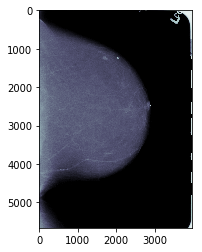

In [66]:
root_dir = '/scratch/bva212/breastCancerData/'
excel_path = '/home/nhl256/BreastCancer/'
df = pd.read_csv(os.path.join(excel_path, 'calc_case_description_test_set.csv'))
idx = 4
image_name = os.path.join(root_dir, df['image file path'][idx])
image_name
ds = pydicom.dcmread(image_name)
plt.imshow(ds.pixel_array, cmap=plt.cm.bone) 

In [3]:
cal_test = pd.read_csv('/home/nhl256/BreastCancer/calc_case_description_test_set.csv')
cal_train = pd.read_csv('/home/nhl256/BreastCancer/calc_case_description_train_set.csv')
mass_test = pd.read_csv('/home/nhl256/BreastCancer/mass_case_description_test_set.csv')
mass_train = pd.read_csv('/home/nhl256/BreastCancer/mass_case_description_train_set.csv')

In [ ]:
# Prepare for train and test set

In [6]:
cal_test.columns

Index(['patient_id', 'breast density', 'left or right breast', 'image view',
       'abnormality id', 'abnormality type', 'calc type', 'calc distribution',
       'assessment', 'pathology', 'subtlety', 'image file path',
       'cropped image file path', 'ROI mask file path'],
      dtype='object')

In [8]:
mass_test.columns

Index(['patient_id', 'breast_density', 'left or right breast', 'image view',
       'abnormality id', 'abnormality type', 'mass shape', 'mass margins',
       'assessment', 'pathology', 'subtlety', 'image file path',
       'cropped image file path', 'ROI mask file path'],
      dtype='object')

In [17]:
cal_test = cal_test[['patient_id','left or right breast', 'image view',
        'pathology', 'image file path',
       'cropped image file path', 'ROI mask file path']]
mass_test = mass_test[['patient_id','left or right breast', 'image view',
        'pathology', 'image file path',
       'cropped image file path', 'ROI mask file path']]
test = pd.concat([cal_test, mass_test], axis=0)
test = shuffle(test)

In [20]:
test['class'] = 0

In [30]:
test.loc[test['pathology'] == 'BENIGN_WITHOUT_CALLBACK', 'class'] = 1
test.loc[test['pathology'] == 'MALIGNANT', 'class'] = 2

In [33]:
cal_train = cal_train[['patient_id','left or right breast', 'image view',
        'pathology', 'image file path',
       'cropped image file path', 'ROI mask file path']]
mass_train = mass_train[['patient_id','left or right breast', 'image view',
        'pathology', 'image file path',
       'cropped image file path', 'ROI mask file path']]
train = pd.concat([cal_train, mass_train], axis=0)
train = shuffle(train)

In [37]:
train['class'] = 0
train.loc[train['pathology'] == 'BENIGN_WITHOUT_CALLBACK', 'class'] = 1
train.loc[train['pathology'] == 'MALIGNANT', 'class'] = 2

In [41]:
train_size = int(len(train) * 0.8)

In [45]:
train_df = train[:train_size]
validation_df = train[train_size:]

In [53]:
### Save these train, valid, test to csv files
train_df.to_csv('trainSet.csv')
validation_df.to_csv('validationSet.csv')
test.to_csv('testSet.csv')

In [54]:
train_transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize([224,224]),
        #transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

validation_transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize([224,224]),
        #transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

class MamogramDataset(Dataset):

    def __init__(self, csv_file, root_dir, excel_path, 
                image_column, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file filename information.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
            image_column: column name from csv file where we take the file path
        """
        self.data_frame = pd.read_csv(os.path.join(excel_path, csv_file))
        self.root_dir = root_dir
        self.excel_path = excel_path 
        self.transform = transform
        self.image_column = image_column

    def __len__(self):
        return len(self.data_frame)

    def __getitem__(self, idx):
        image_name = os.path.join(self.root_dir, 
                                  self.data_frame[image_column][idx])
        
        #some cases io.imread brings more channels than 1 due to bitsize issues
        #image = io.imread(img_name)
        image = pydicom.dcmread(image_name)
        if len(image.shape) > 2 and image.shape[2] == 4:
            image = image[:,:,0]

        # replicate the image into 3 RGB channels
        image=np.repeat(image[None,...],3,axis=0)
        
        image_class = self.data_frame.iloc[idx, -1]
        
        if self.transform:
            image = self.transform(image)
            
        sample = {'x': image, 'y': image_class}

        return sample

In [55]:
## Defining the data loaders with emprical batch size 
BATCH_SIZE = 16

## Need to define root_dir
root_dir = '/scratch/bva212/breastCancerData/'
excel_path = '/home/nhl256/BreastCancer/'
image_column = 'image file path'

In [56]:
Mamogram_TrainData = MamogramDataset(csv_file='trainSet.csv',
                                    root_dir = '/scratch/bva212/breastCancerData/', 
                                    excel_path = '/home/nhl256/BreastCancer/', 
                                    image_column = 'image file path', 
                                    transform=None)
train_loader = DataLoader(Mamogram_TrainData, batch_size=BATCH_SIZE,
                        shuffle=True, num_workers=4)

Mamogram_ValidationData = MamogramDataset(csv_file='validationSet.csv',
                                    root_dir = '/scratch/bva212/breastCancerData/', 
                                    excel_path = '/home/nhl256/BreastCancer/', 
                                    image_column = 'image file path', 
                                    transform=None)
validation_loader = DataLoader(Mamogram_ValidationData, batch_size=BATCH_SIZE,
                        shuffle=True, num_workers=4)

Mamogram_TestData = MamogramDataset(csv_file='testSet.csv',
                                    root_dir = '/scratch/bva212/breastCancerData/', 
                                    excel_path = '/home/nhl256/BreastCancer/', 
                                    image_column = 'image file path', 
                                    transform=None)
test_loader = DataLoader(Mamogram_TestData, batch_size=BATCH_SIZE,
                        shuffle=True, num_workers=4)

In [122]:
from DataLoader import *
import DataLoader

In [93]:
## Defining the data loaders with emprical batch size 
BATCH_SIZE = 16
NUM_WORKER = 3
## Need to define root_dir
root_dir = '/scratch/bva212/breastCancerData/'
excel_path = '/home/nhl256/BreastCancer/'
image_column = 'image file path'

In [78]:
train_csv = 'trainSet.csv'
validation_csv = 'validationSet.csv'
test_csv = 'testSet.csv'

In [81]:
train_transform = None
validation_transform = None


In [128]:
train_loader_t, validation_loader_t, test_loader_t = DataLoader.getLoader(train_csv, validation_csv, test_csv, 
              root_dir, excel_path, image_column,
              train_transform, validation_transform,
              batch_size=BATCH_SIZE, num_workers=NUM_WORKER)

TypeError: getLoader() missing 1 required positional argument: 'shuffle'